<a href="https://colab.research.google.com/github/chajmz/Dataquest/blob/master/Orbit_PEDS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json
from pandas.io.json import json_normalize    
from datetime import datetime
from datetime import date
from google.colab import drive

In [2]:
from google.colab import drive
drive.mount('/gdrive',force_remount=True)
#%cd /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
with open("/gdrive/My Drive/orbit_big.csv",encoding='utf-16') as data_file:    
    df = pd.read_csv(data_file)  

In [0]:
with open("/gdrive/My Drive/exam_all_part1.csv",encoding='utf-16') as data_file:    
    df_part1 = pd.read_csv(data_file)  

with open("/gdrive/My Drive/exam_all_part2.csv",encoding='utf-16') as data_file:    
    df_part2 = pd.read_csv(data_file)
    
with open("/gdrive/My Drive/exam_part3.csv",encoding='utf-16') as data_file:    
    df_part3 = pd.read_csv(data_file)        

In [59]:
df_part_merged = pd.concat([df_part1,df_part2,df_part3])
df_part_merged.shape

(118299, 15)

In [0]:
dic_rename_orbit = {
    "Notes":"NO",
    "Legal status (Pending, Granted, Revoked, Expired, Lapsed)": "ACT.STATUS",
    "Earliest priority date":"EPRD",
    "Earliest application date":"EAPD",
    "Earliest publication date":"EPD",
    "Earliest grant date":"EPDG",
    "Title":"TI"
}

In [0]:
df_part_merged = df_part_merged.rename(columns=dic_rename_orbit)
df_part_merged.sample(5)

In [0]:
with open("/gdrive/My Drive/unit.csv") as data_file:    
    df_art_unit = pd.read_csv(data_file) 

# Helper Functions
Toutes les fonctions de transformation des DF


In [0]:
pattern_examiner = r'[|]{2}([Pp][rimary]\w*\s\w*)[\:]([\s\w-]*)[|]+'
pattern_art_unit = r'[|]+([Aa]\w*\s[Uu]\w*[.: ]*\w{3}[=]+)([0-9]+)[|]+'
pattern_extension = r'\s([Ee]+\w{3}[=]+)([0-9]+)[|]+'
pattern_clms = r'\s([NnCcLl]{3}[=]+)([0-9]+)[|]+'
pattern_draw = r'\s([NnDdRr]{3}[=]+)([0-9]+)[|]+'
pattern_title = r'[(](\w{2}[D]?[0-9]+)[)][|]([\w, ().:=?-]+)'
pattern_rep = r'[(]US[0-9]+[)][|]([\w.\s&,;()\[\]]*)[|]'

assignees_list = ['THALES','BOEING','AIRBUS','HONEYWELL','SAFRAN','COLLINS','BAE SYSTEMS','GARMIN','PANASONIC','ROSEMOUNT','ELBIT','GE AVIATION'] 

In [0]:
def applyPattern(df_csv):
  df_csv['art_unit'] = df_csv['NO'].str.extract(pattern_art_unit)[1]
  df_csv['extension_days'] = df_csv['NO'].str.extract(pattern_extension)[1]
  df_csv['examiner'] = df_csv['NO'].str.extract(pattern_examiner)[1]
  df_csv['draw_nb'] = df_csv['NO'].str.extract(pattern_draw)[1]
  df_csv['clms_nb'] = df_csv['NO'].str.extract(pattern_clms)[1]
  df_csv['clean_title'] = df_csv['TI'].str.extract(pattern_title)[1]
  df_csv['clean_num'] = df_csv['TI'].str.extract(pattern_title)[0]
  df_csv['representative'] = df_csv['Representative'].str.extract(pattern_rep)[0]
  return df_csv

In [0]:
#Date format %Y-%m-%d
def transformDate(df):
  for c in ['EPRD', 'EAPD', 'EPD','EPDG']:
    df[c] = pd.to_datetime(df[c])
  df['days_grant'] = df['EPDG'] - df['EPRD']
  return df

In [0]:
def getArtUnit(df_csv):
    #Let's extract first 2 num of group art unit
  df_csv['prefix_art'] = df_csv['art_unit'].str[:2]
  df_csv['suffix_art'] = df_csv['art_unit'].str[2:]
  return df_csv

In [0]:
def getTopPrefixForAssignee(assignee,n,df):
  df_a = df[df['PA'].str.contains(assignee)]
  top_prefix = df_a['prefix_art'].value_counts()
  return (top_prefix[top_prefix>n],assignee)

def normalizeAssignee(df):
  list_df = []
  df['norm_assignee'] = 'OTHER'
  for a in assignees_list:
    sub_df = df[df['PA'].str.contains(a)]
    sub_df['norm_assignee'] = a
    list_df.append(sub_df)
  list_df.append(df[df['PA'] == 'OTHER'])
  return pd.concat(list_df,axis=0)


In [39]:
def is_cjk(character):
    """"
    Checks whether character is CJK.

        >>> is_cjk(u'\u33fe')
        True
        >>> is_cjk(u'\uFE5F')
        False

    :param character: The character that needs to be checked.
    :type character: char
    :return: bool
    """
    return any([start <= ord(character) <= end for start, end in 
                [(4352, 4607), (11904, 42191), (43072, 43135), (44032, 55215), 
                 (63744, 64255), (65072, 65103), (65381, 65500), 
                 (131072, 196607)]
                ])
    
def isExaminerCJK(s):
  for c in s:
    if is_cjk(c):
      return True
  return False

isExaminerCJK('AAPOKMAKAMMA KALKJKLJLKA--')

False

In [0]:
from datetime import date
def getAssigneeDataFrame(assignee,df):
  return df[df['norm_assignee'] == assignee]

def computeTimeSinceFiling(df):
  df['days_filing'] = datetime.today() - df['EPRD']
  return df

def avgTimeToGrant(df):
  dic = {}
  for a in assignees_list:
    df_a = getAssigneeDataFrame(a,df)
    df_a = df_a[df_a['EPDG'].notnull()]
    dic[a] = df_a['days_grant'].mean().days
  return dic

In [0]:
def getListExaminer(df,n):
  top_df = df[df['num_case'] > n]
  return top_df['examiner'].unique()

In [0]:
#First value is examiner
#Second is mean days for grant patent
#Third is max value for granting a patent
#Fourth is the min days required for granting a patent
#Fifth is the number of case processed by the examiner
#Sixth is finally the group_art unit in which the examiner contribute the most
#Seventh is the company the most processed by the examiner (might be Boeing, Airbus or Safran due to the number ...)

def computeExaminersStats(df):  
  all_l = []
  all_ex = df[df['examiner'].notnull()]['examiner'].unique()
  for ex in all_ex:
    if isExaminerCJK(ex) == False :
      df_e = df[df['examiner'] == ex]
      meanV = df_e['days_grant'].mean().days
      maxV = df_e['days_grant'].max().days
      minV = df_e['days_grant'].min().days
      num_case = df_e.shape[0]
      art = df_e['art_unit'].value_counts().keys().tolist()[0]
      top_assignee = df_e['norm_assignee'].value_counts().keys().tolist()[0]
      percent_assignee = round((df_e['norm_assignee'].value_counts().head(1)[0])/num_case,1)
      l = [ex,meanV,maxV,minV,num_case,int(art),top_assignee,percent_assignee]
      all_l.append(l)
  return pd.DataFrame(all_l, columns=['examiner','avg_for_grant','max_for_grant','min_for_grant','num_case','top_art_unit','top_assignee_processed','assignee_percent'])

In [0]:
#################### GRAPH FUNCTION #################

def getYearFilingForAssignee(assignee,df):
  df = getAssigneeDataFrame(assignee,df)
  #g = df['EPRD'].dt.year.value_counts().sort_index().plot(kind='bar')
  g = sns.barplot(y=df['EPRD'].dt.year.value_counts().sort_index().values, x=df['EPRD'].dt.year.value_counts().sort_index().index)
  g.set_xlabel('Year of Filing')
  g.set_ylabel('Number of Patent Filed')
  g.set_title('Year of Filing for ' + assignee)
  return g

# Main

In [0]:
####### MAIN SCRIPT #######

def applyAllTransformations(df):
  df_all = applyPattern(df)
  df_all = getArtUnit(df_all)
  df_all = transformDate(df_all)
  df_all = computeTimeSinceFiling(df_all)
  df_all['granted_bool'] = df_all['days_grant'].notnull()

  return df_all

In [0]:
df_all = applyAllTransformations(df_part_merged)

In [159]:
df_all['ACT.STATUS'][74825] 
#74825 100696 110658

'(US9840063B2)|GRANTED|(FR2995244B1)|GRANTED|(CN103660309BB)|GRANTED'

# Visualisation des données


Text(12.334999999999994, 0.5, 'Assignees')

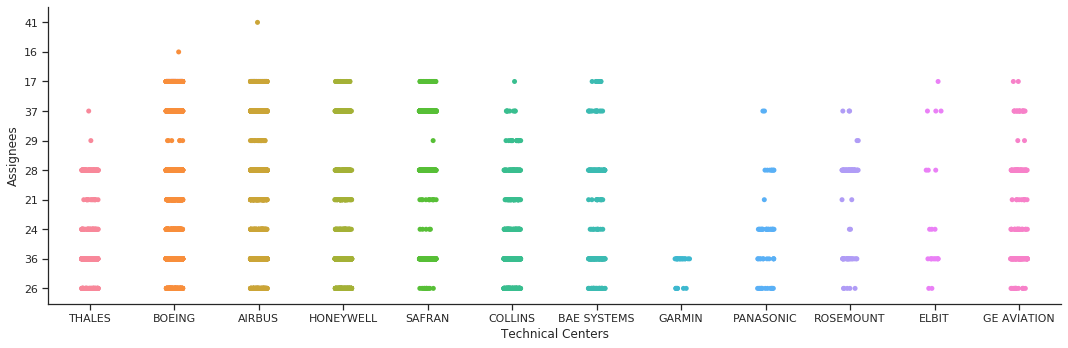

In [16]:
list_top_prefix = [getTopPrefixForAssignee(assignee,0,df) for assignee in assignees_list]
#sns.distplot( y=list_top_prefix[0][0], x=df_l_exam['prefix_art'] )
sns.set(style="ticks", color_codes=True)
fig_sns = sns.catplot(x="norm_assignee", y="prefix_art", data=df[df['prefix_art'].notnull()],height = 5,aspect=3)
plt.xlabel('Technical Centers')
plt.ylabel('Assignees')

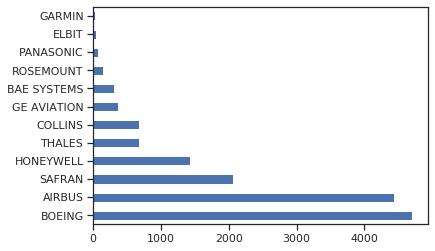

In [17]:
df['norm_assignee'].value_counts(dropna=True).head(30).plot(kind='barh')

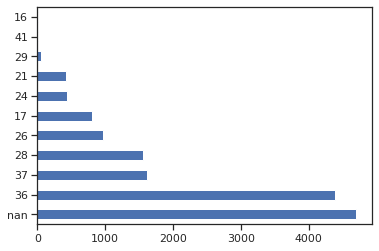

In [18]:
df['prefix_art'].value_counts(dropna=False).plot(kind='barh')

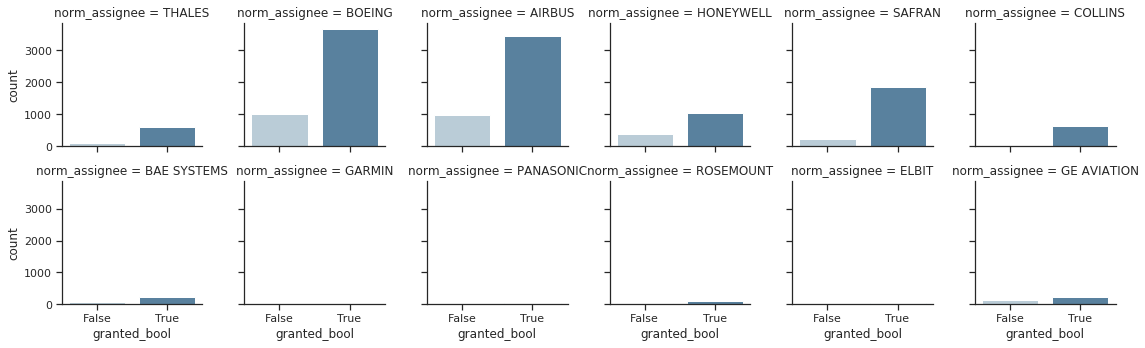

In [19]:
from  matplotlib.ticker import PercentFormatter
g = sns.catplot("granted_bool", col="norm_assignee", col_wrap=6,data=df, kind="count", height=2.5, aspect=1.05,palette="Blues",saturation=.5) 

plt.show()

(453,)

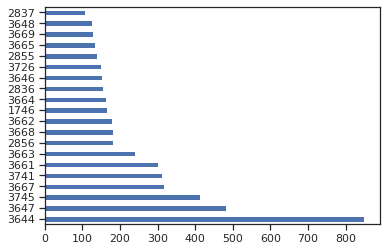

In [20]:
df['art_unit'].value_counts().head(20).plot(kind='barh')
df['art_unit'].value_counts().shape

242

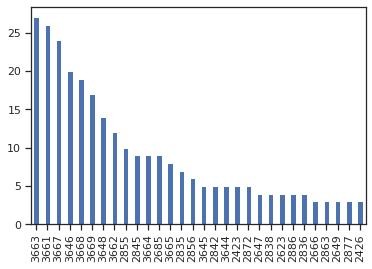

In [21]:
df_thales = df[df['norm_assignee'] == 'THALES']
df_t = df_thales['art_unit'].value_counts().head(30).plot(kind='bar')
df_t_sum = df_thales['art_unit'].value_counts().head(20).sum()
df_t_sum

In [22]:
df_thales['art_unit'].value_counts().describe()

count    140.000000
mean       3.071429
std        4.679118
min        1.000000
25%        1.000000
50%        1.000000
75%        3.000000
max       27.000000
Name: art_unit, dtype: float64

count    169.000000
mean       3.804734
std        6.465364
min        1.000000
25%        1.000000
50%        2.000000
75%        3.000000
max       50.000000
Name: art_unit, dtype: float64

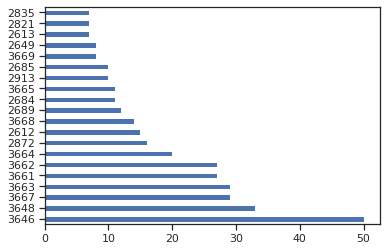

In [23]:
df_c = df[df['norm_assignee'] == 'COLLINS']
df_collins = df_c['art_unit'].value_counts().head(20).plot(kind='barh')
df_c['art_unit'].value_counts().describe()

In [0]:
#Les art units avec les meilleurs stats
#Les examinateurs avec les meilleurs stats dans un même art unit
#moyenne générale dans un art unit 
#calcul du temps depuis la première prio 
#temps moyen pour délivrer brevet par acteur
#examinateur meme si pas delivré ?
#stat par examinateur

In [0]:
df_dic = pd.DataFrame([dic_avg]).T
df_dic = df_dic.rename(columns={df_dic.columns[0]:'avg_day'})

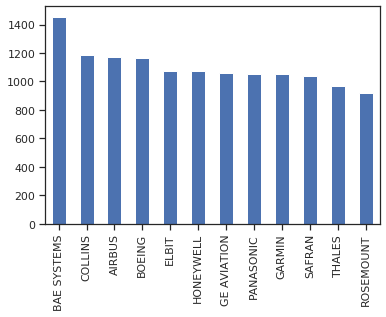

In [30]:
df_dic['avg_day'].sort_values(ascending=False).plot(kind='bar')

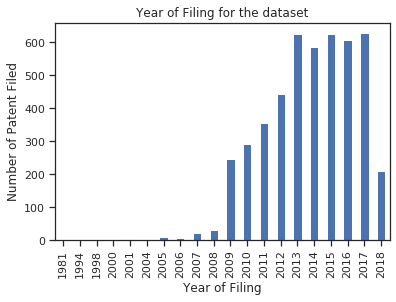

In [32]:
th = getYearFilingForAssignee('BOEING',df)

In [0]:
df['priority_year'] =  df['EPRD'].dt.year

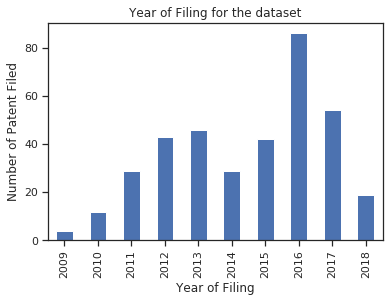

In [34]:
ge = getYearFilingForAssignee('GE AVIATION',df)

In [35]:
exam_thales = df_thales['examiner'].value_counts()
exam_thales_2 = exam_thales[exam_thales>2]
exam_thales_2

 Tarcza Thomas          14
 Cheung Calvin           7
 Cheung Mary             7
 Black Thomas G          6
 Olszewski John R        6
 Nguyen Tan Q            6
 Edwards Jerrah          5
 Sotomayor John B        4
 Phan Dao                4
 Khatib Rami             4
 Nguyen John Q           4
 Trammell James          4
 Patel Harshad R         4
 Camby Richard           4
 Bruckart Benjamin R     4
 Ratcliffe Luke          4
 Nguyen Tai T            3
 Nguyen Sang             3
 Badii Behrang           3
 Brainard Timothy A      3
 Marc-Coleman Marthe     3
 Lin Abby Y              3
 Tran Khoi               3
 Shafi Muhammad          3
 Gregory Bernarr         3
 Barker Matthew M        3
 Gregory Bernarr E       3
Name: examiner, dtype: int64

In [36]:
#peut on avoir un examiner si pas granted ? 
df_b_exam = df_boeing[df_boeing['granted_bool'] == False]

print(df_b_exam[df_b_exam['FD'].notnull()]['FD'])


329      (US20180362149)|Provisional Appl: US62/519,693...
543      (US20190241247)|Provisional Appl: US62/628,254...
761      (US20190144112)|CIP of: US15/815,689 FDD=2017-...
1426     (US20190048959)|Continuation of: US15/867,940 ...
1796     (US20190080615)|CIP of: US15/703,053 FDD=2017-...
                               ...                        
14507    (US20190270296)|Provisional Appl: US62/638,055...
14509    (US20190241752)|Provisional Appl: US62/625,785...
14510    (US20190240635)|Provisional Appl: US62/625,792...
14516    (US20190002739)|Provisional Appl: US62/527,432...
14828    (US20180255455)|CIP of: US15/451,291 FDD=2017-...
Name: FD, Length: 72, dtype: object


In [37]:
print(df_b_exam['FD'][1796])

(US20190080615)|CIP of: US15/703,053 FDD=2017-09-13 [2017US-15703053]


In [38]:
all_ex = df[df['examiner'].notnull()]['examiner'].unique()
all_l = []
all_ex[0]
df_e = df[df['examiner'] == all_ex[0]]
df_e

,PR.§1,AP.§1,PN.PN,FAN,FAMILY_PN,EPRD,EAPD,EPD,EPDG,ACT.EED,TI,AB,PA,IN,RP,ADB,ICLM,OBJ,KEYW,KWIC,PCL,ACT.STATUS,ACT,DS,EPRC,NO,FD,days_grant,art_unit,extension_days,examiner,draw_nb,clms_nb,clean_title,clean_num,prefix_art,suffix_art,norm_assignee,granted_bool,days_filing,priority_year
10,2016FR-0001112,"US15/652,801|FR1601112|CN201710585460",US10453234|FR3054314|US20180075632|CN107628258...,78601936,US10453234 B2 2019-10-22 [US10453234]...,2016-07-19,2016-07-19,2018-01-26,2018-08-31,(US10453234B2)|2037-07-18|(FR3054314B1)|2036-0...,(US10453234)|System for displaying avionic dat...,(US10453234)|The present invention relates to ...,THALES,Baron Luc|Garnavault Christophe|Aymeric Bruno|...,(US10453234)|Pearne & Gordon LLP|(FR3054314)|C...,(US10453234)|Other devices typically make it p...,(US10453234)|1. A system for displaying avioni...,(US10453234)|The present invention relates to ...,"(US10453234)|DISPLAY FORMAT(100,96)|AIRCRAFT(1...",AB|(US10453234)|The present invention relates ...,NaN,(US10453234B2)|GRANTED|(FR3054314B1)|GRANTED|(...,(US10453234)|LEGAL DETAILS FOR US20180075632|A...,NaN,FR,(US20180075632)|Number of Drawings: NDR=4||Num...,(US10453234)|Previous publication: US201800756...,773 days,2611,NaN,Wu Yanna,4,10,System for displaying avionic data on at least...,US10453234,26,11,THALES,True,1203 days 17:46:08.665553,2016
11794,2016US-15185785,"US15/185,785",US10417803|US20170365086,78089253,US10417803 B2 2019-09-17 [US10417803]...,2016-06-17,2016-06-17,2017-12-21,2019-09-17,2036-06-17,(US10417803)|Multiple-pass rendering of a digi...,(US10417803)|A method is provided for renderin...,BOEING,FLOYD JOSEPH FRANK|EAMES PATRICK JAMES|HADLEY ...,(US10417803)|Womble Bond Dickinson (US) LLP,(US10417803)|Display of an aircraft and its pa...,(US10417803)|1. An apparatus for rendering a s...,(US10417803)|The present disclosure relates ge...,"(US10417803)|PASS RENDERING(100,49)|SCENE(100,...",ADB|(US10417803)|Display of an aircraft and it...,NaN,GRANTED,(US10417803)|LEGAL DETAILS FOR US20170365086|A...,NaN,US,(US20170365086)|Number of Drawings: NDR=6||Num...,(US10417803)|Previous publication: US201703650...,1187 days,2611,NaN,Wu Yanna,6,24,Multiple-pass rendering of a digital three-dim...,US10417803,26,11,BOEING,True,1235 days 17:46:08.665553,2016


In [42]:
df_exam_s.sample(10)

,examiner,avg_for_grant,max_for_grant,min_for_grant,num_case,top_art_unit,top_assignee_processed,assignee_percent
1759,Rogers Adam D,741,764,718,2,3656,SAFRAN,0.5
924,Siconolfi Robert A,1286,1729,712,4,3657,HONEYWELL,0.5
1544,Egloff Peter,2722,2722,2722,1,3715,BOEING,1.0
1857,Deodhar Omkar,760,760,760,1,3714,AIRBUS,1.0
2258,Ip Paul,805,805,805,1,2837,SAFRAN,1.0
1808,Kassa Zewdu,738,738,738,1,2632,AIRBUS,1.0
1486,Valone Thomas,865,865,865,1,2858,BOEING,1.0
722,Lee Katarzyna Wyrozebski,1226,1727,585,5,1746,BOEING,0.8
1998,Srivastava Vivek,1355,1355,1355,1,2449,HONEYWELL,1.0
1761,Ryan Patrick,1074,1413,735,2,1726,BAE SYSTEMS,0.5


In [43]:
df_exam_s['num_case'] = df_exam_s['num_case'].astype(int)
df_exam_s['prefix_art'] = round(df_exam_s['top_art_unit']/100,0)
df_exam_s.sample(4)

,examiner,avg_for_grant,max_for_grant,min_for_grant,num_case,top_art_unit,top_assignee_processed,assignee_percent,prefix_art
1127,Schwenning Lynn E,1490,1490,1490,1,3652,BOEING,1.0,37.0
1431,Minskey Jacob Thomas,833,833,833,1,1741,BOEING,1.0,17.0
2191,Kotter Kip T,746,746,746,1,3617,SAFRAN,1.0,36.0
437,Fleming Fritz M,1300,1905,768,10,2836,SAFRAN,0.7,28.0


In [0]:
df_high_exam = df_exam_s[df_exam_s['num_case']>4]

In [45]:
df_high_exam

,examiner,avg_for_grant,max_for_grant,min_for_grant,num_case,top_art_unit,top_assignee_processed,assignee_percent,prefix_art
1,Cheung Mary,796,1691,272,64,3667,AIRBUS,0.3,37.0
2,Cheung Calvin,971,1652,518,44,3668,AIRBUS,0.3,37.0
3,Edwards Jerrah,986,2015,524,29,3667,AIRBUS,0.2,37.0
4,Trammell James,1047,2175,350,47,3667,AIRBUS,0.3,37.0
6,Butler Rodney,755,1076,468,15,3667,AIRBUS,0.4,37.0
...,...,...,...,...,...,...,...,...,...
2048,Nguyen Andrew H,1053,1729,756,6,3741,SAFRAN,0.7,37.0
2192,Joyce William C,881,1278,742,8,3658,SAFRAN,1.0,37.0
2210,Seabe Justin D,933,1594,552,10,3745,SAFRAN,1.0,37.0
2216,Edgar Richard A,1228,1764,552,7,3745,SAFRAN,1.0,37.0


In [46]:
df['art_unit'].value_counts().head(20)

3644    848
3647    483
3745    414
3667    317
3741    311
3661    302
3663    241
2856    182
3668    181
3662    178
1746    167
3664    164
2836    154
3646    152
3726    150
2855    138
3665    134
3669    129
3648    126
2837    108
Name: art_unit, dtype: int64

In [0]:
#17XX = Chemical and Materials Engineering fields.
#28XX = Semiconductors, Electrical and Optical Systems and Components
#24XX = Computer Networks, Multiplex, Cable and Cryptography/Security.
#21XX = Computer Architecture Software and Information Security.
#28XX = Semiconductors, Electrical and Optical Systems and Components.
#29XX = including Designs.
#36XX = Transportation, Electronic Commerce, Construction, Agriculture, Licensing and Review.
#37XX = Mechanical Engineering, Manufacturing and Products.


In [47]:
df_art_unit['prefix_art'] = round(df_art_unit['Art Unit']/100,0)
df_art_unit.sample(4)

,Art Unit,Class,Class Title,Subclass Ranges From,Subclass Ranges To,prefix_art
71,1625,514,"DRUG, BIO-AFFECTING AND BODY TREATING COMPOSIT...",671,NaN,16.0
239,1645,424,"DRUG, BIO-AFFECTING AND BODY TREATING COMPOSIT...",282.1,283.1,16.0
820,2121,706,DATA PROCESSING: ARTIFICIAL INTELLIGENCE,900,FOR 131,21.0
563,1762,523,SYNTHETIC RESINS OR NATURAL RUBBERS -- PART OF...,180,181,18.0


In [0]:
#Let's focus on direct competitors : GE, HWL & RC
df_competitors = df[(df.norm_assignee == 'ELBIT') | (df.norm_assignee == 'GARMIN') | (df.norm_assignee == 'THALES') | (df.norm_assignee == 'GE AVIATION') | (df.norm_assignee == 'COLLINS') | (df.norm_assignee == 'HONEYWELL')]
df_competitors.sample(10)

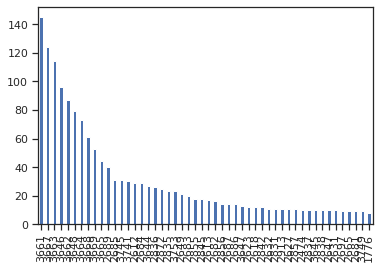

In [49]:
top_art_competitors = df_competitors['art_unit'].value_counts()
top_art_competitors.head(50).plot(kind='bar')

In [50]:
mean_comp_art = df_competitors['art_unit'].value_counts().mean()
list_top = top_art_competitors[top_art_competitors>mean_comp_art]
list_top.index

Index(['3661', '3667', '3663', '3646', '3662', '3648', '3664', '3668', '3669',
       '3665', '2689', '2685', '3745', '3741', '2612', '2684', '3644', '2836',
       '2872', '2835', '3753', '2649', '2683', '2855', '2845', '2613', '2682',
       '2856', '2687', '2686', '3647', '2623', '2618', '2842', '2632', '2831',
       '2913', '2627', '2857', '2474', '2837', '3645', '2838', '2647', '2631',
       '2697', '2665', '2681', '3749', '1776', '2113', '2834', '3658', '3657',
       '2821', '3653'],
      dtype='object')

In [53]:
merged_exam = pd.merge(df_competitors_copy,df_exam_copy,on='examiner')
merged_exam.sample(4)

,PR.§1,AP.§1,PN.PN,FAN,FAMILY_PN,EPRD,EAPD,EPD,EPDG,ACT.EED,TI,AB,PA,IN,RP,ADB,ICLM,OBJ,KEYW,KWIC,PCL,ACT.STATUS,ACT,DS,EPRC,NO,FD,days_grant,art_unit,extension_days,examiner,draw_nb,clms_nb,clean_title,clean_num,prefix_art_x,suffix_art,norm_assignee,granted_bool,days_filing,priority_year,avg_for_grant,max_for_grant,min_for_grant,num_case,top_art_unit,top_assignee_processed,assignee_percent,prefix_art_y
1034,2009FR-0005724,"US12/954,152|EP10192158|FR0905724",US8615480|EP2328115|US20110213749|FR2953305|EP...,15014681,US8615480 B2 2013-12-24 [US8615480]|...,2009-11-27,2009-11-27,2011-06-01,2013-11-20,(US8615480B2)|2031-08-23|(FR2953305A1)|2029-11...,"(US8615480)|Method, device and system for the ...","(US8615480)|The invention relates to a method,...",THALES,PICHON FREDERIC,(US8615480)|Baker & Hostetler LLP|(FR2953305)|...,(US8615480)|The method according to the invent...,(US8615480)|1. A method for the fusion of info...,"(US8615480)|The invention relates to a method,...","(US8615480)|BELIEF FUNCTION(100,37)|KNOWLEDGE(...",ADB|(US8615480)|The method according to the in...,PCLO=706046000,(US8615480B2)|GRANTED|(FR2953305A1)|PENDING|(E...,(US8615480)|LEGAL DETAILS FOR US20110213749|Ac...,(EP2328115)|Contracting States: AL AT BE BG C...,FR,(US20110213749)|Number of Drawings: NDR=2||Num...,(US8615480)|Previous publication: US2011021374...,1454 days,2129,272,Gaffin Jeffrey A,2,11,"Method, device and system for the fusion of in...",US8615480,21,29,THALES,True,3629 days 17:46:08.665553,2009,1083,1454,668,5,2129,BOEING,0.8,21.0
497,2014US-14216335,"CN201510022098|EP15150993|US14/216,335",CN104925267|EP2921825|US9340282|CN104925267|EP...,70907962,US9340282 B2 2016-05-17 [US9340282]|...,2014-03-17,2014-03-17,2015-09-17,2016-05-17,(US9340282B2)|2034-03-17|(EP2921825B1)|2035-01...,(US9340282)|System and method for displaying v...,(US9340282)|A method and system for maintainin...,HONEYWELL INTERNATIONAL,CASE TIMOTHY JOHN|MEEKER JOHN,"(US9340282)|Ingrassia Fisher & Lorenz, P.C.|(E...",(US9340282)|In addition to the pressure associ...,(US9340282)|1. A method for providing visual v...,(US9340282)|A method and system for maintainin...,"(CN104925267B)|ROTARY WING AIRCRAFT(100,28)|VE...",AB|(US9340282)|A method and system for maintai...,PCLO=701004000,(US9340282B2)|GRANTED|(EP2921825B1)|GRANTED|(C...,(US9340282)|LEGAL DETAILS FOR US20150259075|Ac...,(EP2921825)|Contracting States: AL AT BE BG C...,US,(US20150259075)|Number of Drawings: NDR=6||Num...,(US9340282)|Previous publication: US2015025907...,792 days,3668,NaN,Jabr Fadey,6,12,System and method for displaying vertical refe...,US9340282,36,68,HONEYWELL,True,2058 days 17:46:08.665553,2014,971,1712,657,27,3668,AIRBUS,0.4,37.0
935,2014US-14455649,"US14/455,649",US9783317|US20160039371,72186248,US9783317 B2 2017-10-10 [US9783317]|...,2014-08-08,2014-08-08,2016-02-11,2017-10-10,2035-09-16,"(US9783317)|Power converter, generator and arc...",(US9783317)|A high efficiency multifunction po...,HONEYWELL INTERNATIONAL,BLUMER ERIC|ANGHEL CRISTIAN|PEARSON WAYNE,(US9783317)|Shimokaji IP,"(US9783317)|In view of the foregoing, there is...","(US9783317)|1. A power system for an aircraft,...",(US9783317)|The present invention generally re...,"(US9783317)|GENERATOR(100,66)|AIRCRAFT(100,60)...",AB|(US9783317)|A high efficiency multifunction...,PCLO=290031000|PCLX=290045000|PCLX=307009100,GRANTED,(US9783317)|LEGAL DETAILS FOR US20160039371|Ac...,NaN,US,(US20160039371)|Number of Drawings: NDR=16||Nu...,(US9783317)|Previous publication: US2016003937...,1159 days,2831,404,Patel Tulsidas C,16,20,"Power converter, generator and architecture fo...",US9783317,28,31,HONEYWELL,True,1914 days 17:46:08.665553,2014,1085,1496,609,8,2831,AIRBUS,0.2,28.0
1452,2009US-12434763,"US12/434,763|EP10161359|CA2702543",US8305208|EP2249297|CA2702543|US20100277347,4169963,US8305208 B2 2012-11-06 [US8305208]|...,2009-05-04,2009-05-04,2010-11-04,2012-11-06,(US8305208B2)|2030-10-31|(EP2249297A1)|2013-11...,(US8305208)|Aircraft uplink message r

In [55]:
exam_over_3 = getListExaminer(merged_exam,1)
ss = ""
for e in exam_over_3:
  ss += '('+e+')'+" ou "
ss

'( Wu Yanna) ou ( Cheung Mary) ou ( Cheung Calvin) ou ( Edwards Jerrah) ou ( Trammell James) ou ( Su Sarah) ou ( Butler Rodney) ou ( Hailu Teshome) ou ( Wang Quan-Zhen) ou ( Lin Abby Y) ou ( Sample Jonathan L) ou ( Nguyen Tan Q) ou ( Tran Khoi) ou ( Olszewski John R) ou ( Tarcza Thomas) ou ( Amin Bhavesh V) ou ( Zeender Ryan) ou ( Girma Fekadeselassie) ou ( Shaawat Mussa A) ou ( Paige Tyler) ou ( Whittington Jess) ou ( Nguyen Tai T) ou ( Nguyen Steven H) ou ( Nguyen Cuong H) ou ( Benedik Justin) ou ( Badii Behrang) ou ( Nguyen John Q) ou ( Black Thomas G) ou ( Heinle Courtney D) ou ( Luu Le H) ou ( Jos Basil T) ou ( Weber Tamara L) ou ( Khatib Rami) ou ( Nguyen Phung) ou ( Arthur Jeanglaude Gertrude) ou ( Mustafa Imran) ou ( Mott Adam R) ou ( Hellner Mark) ou ( Zanelli Michael J) ou ( Wiltey Nicholas K) ou ( Brainard Timothy A) ou ( Beaulieu Yonel) ou ( Shafi Muhammad) ou ( Brown Drew) ou ( Zimmerman Mark K) ou ( Anwari Maceeh) ou ( Troost Aaron L) ou ( Elchanti Hussein) ou ( Marc-Cole

In [56]:
exam_over_3 = getListExaminer(merged_exam,0)
exam_over_3.shape

(1038,)

In [0]:
df_art_unit['Art Unit'].unique().tolist()